In [ ]:
!pip install --upgrade pip
!pip install numpy==1.24.3
!pip install torch==2.0.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
!pip install networkx scikit-learn
!pip install jetnet --no-cache-dir

Using JetNet dataset
Using device: cuda
Loading JetNet data for analysis...
[██████████████████████████████████████████████████] 100%
[██████████████████████████████████████████████████] 100%
[██████████████████████████████████████████████████] 100%
Particle shape: (368113, 150, 4)
Jet shape: (368113, 4)
Total number of jets in dataset: 368113

=== Sample JetNet jets ===


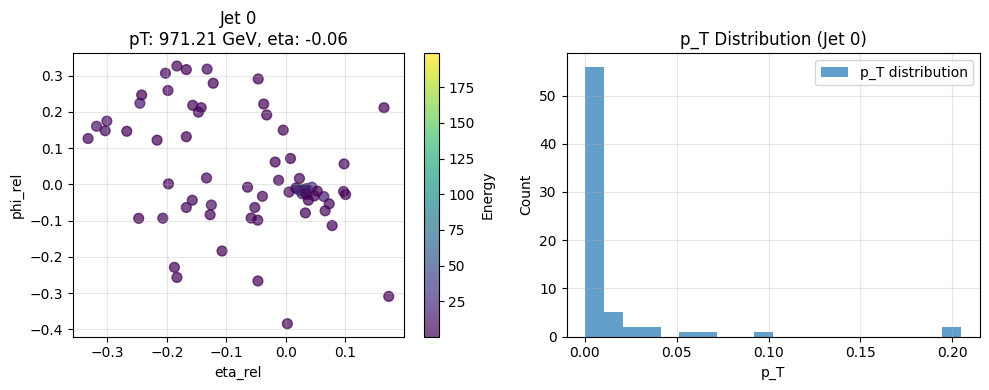

Jet 0 Stats:
Particles: 70
Jet info: [ 9.71209839e+02 -6.02245331e-02  1.08700569e+02  7.00000000e+01]
eta mean: -0.066833936
phi mean: 0.03076208
pt mean: 0.014323129



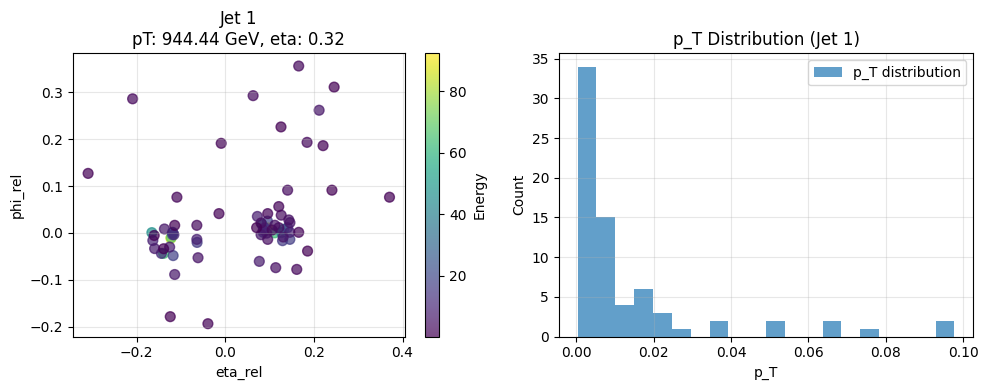

Jet 1 Stats:
Particles: 72
Jet info: [9.44443481e+02 3.21850777e-01 1.24882523e+02 7.20000000e+01]
eta mean: 0.03138647
phi mean: 0.028939048
pt mean: 0.013899596



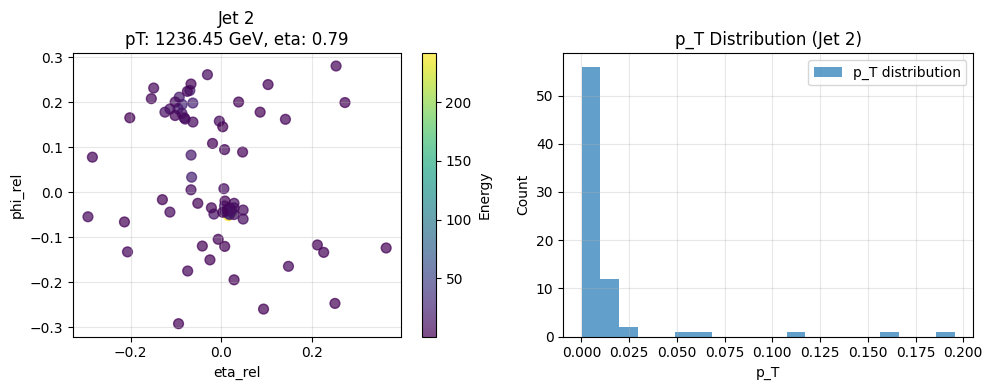

Streaming output truncated to the last 5000 lines.
Particle loss: 0.7657, Mask loss: 0.0200, Count loss: 0.0001
Particle loss: 0.6012, Mask loss: 0.0162, Count loss: 0.0003
Particle loss: 0.7883, Mask loss: 0.0209, Count loss: 0.0003
Particle loss: 0.7408, Mask loss: 0.0198, Count loss: 0.0005
Particle loss: 0.5909, Mask loss: 0.0163, Count loss: 0.0005
Particle loss: 0.6472, Mask loss: 0.0175, Count loss: 0.0001
Particle loss: 0.5808, Mask loss: 0.0306, Count loss: 0.0002
Particle loss: 0.6166, Mask loss: 0.0254, Count loss: 0.0005
Particle loss: 0.8141, Mask loss: 0.0171, Count loss: 0.0004
Particle loss: 0.5505, Mask loss: 0.0198, Count loss: 0.0002
Particle loss: 0.7078, Mask loss: 0.0137, Count loss: 0.0002
Particle loss: 0.8540, Mask loss: 0.0167, Count loss: 0.0002
Particle loss: 0.6565, Mask loss: 0.0142, Count loss: 0.0001
Particle loss: 0.7437, Mask loss: 0.0194, Count loss: 0.0003
Particle loss: 0.6870, Mask loss: 0.0148, Count loss: 0.0002
Particle loss: 0.7825, Mask loss: 

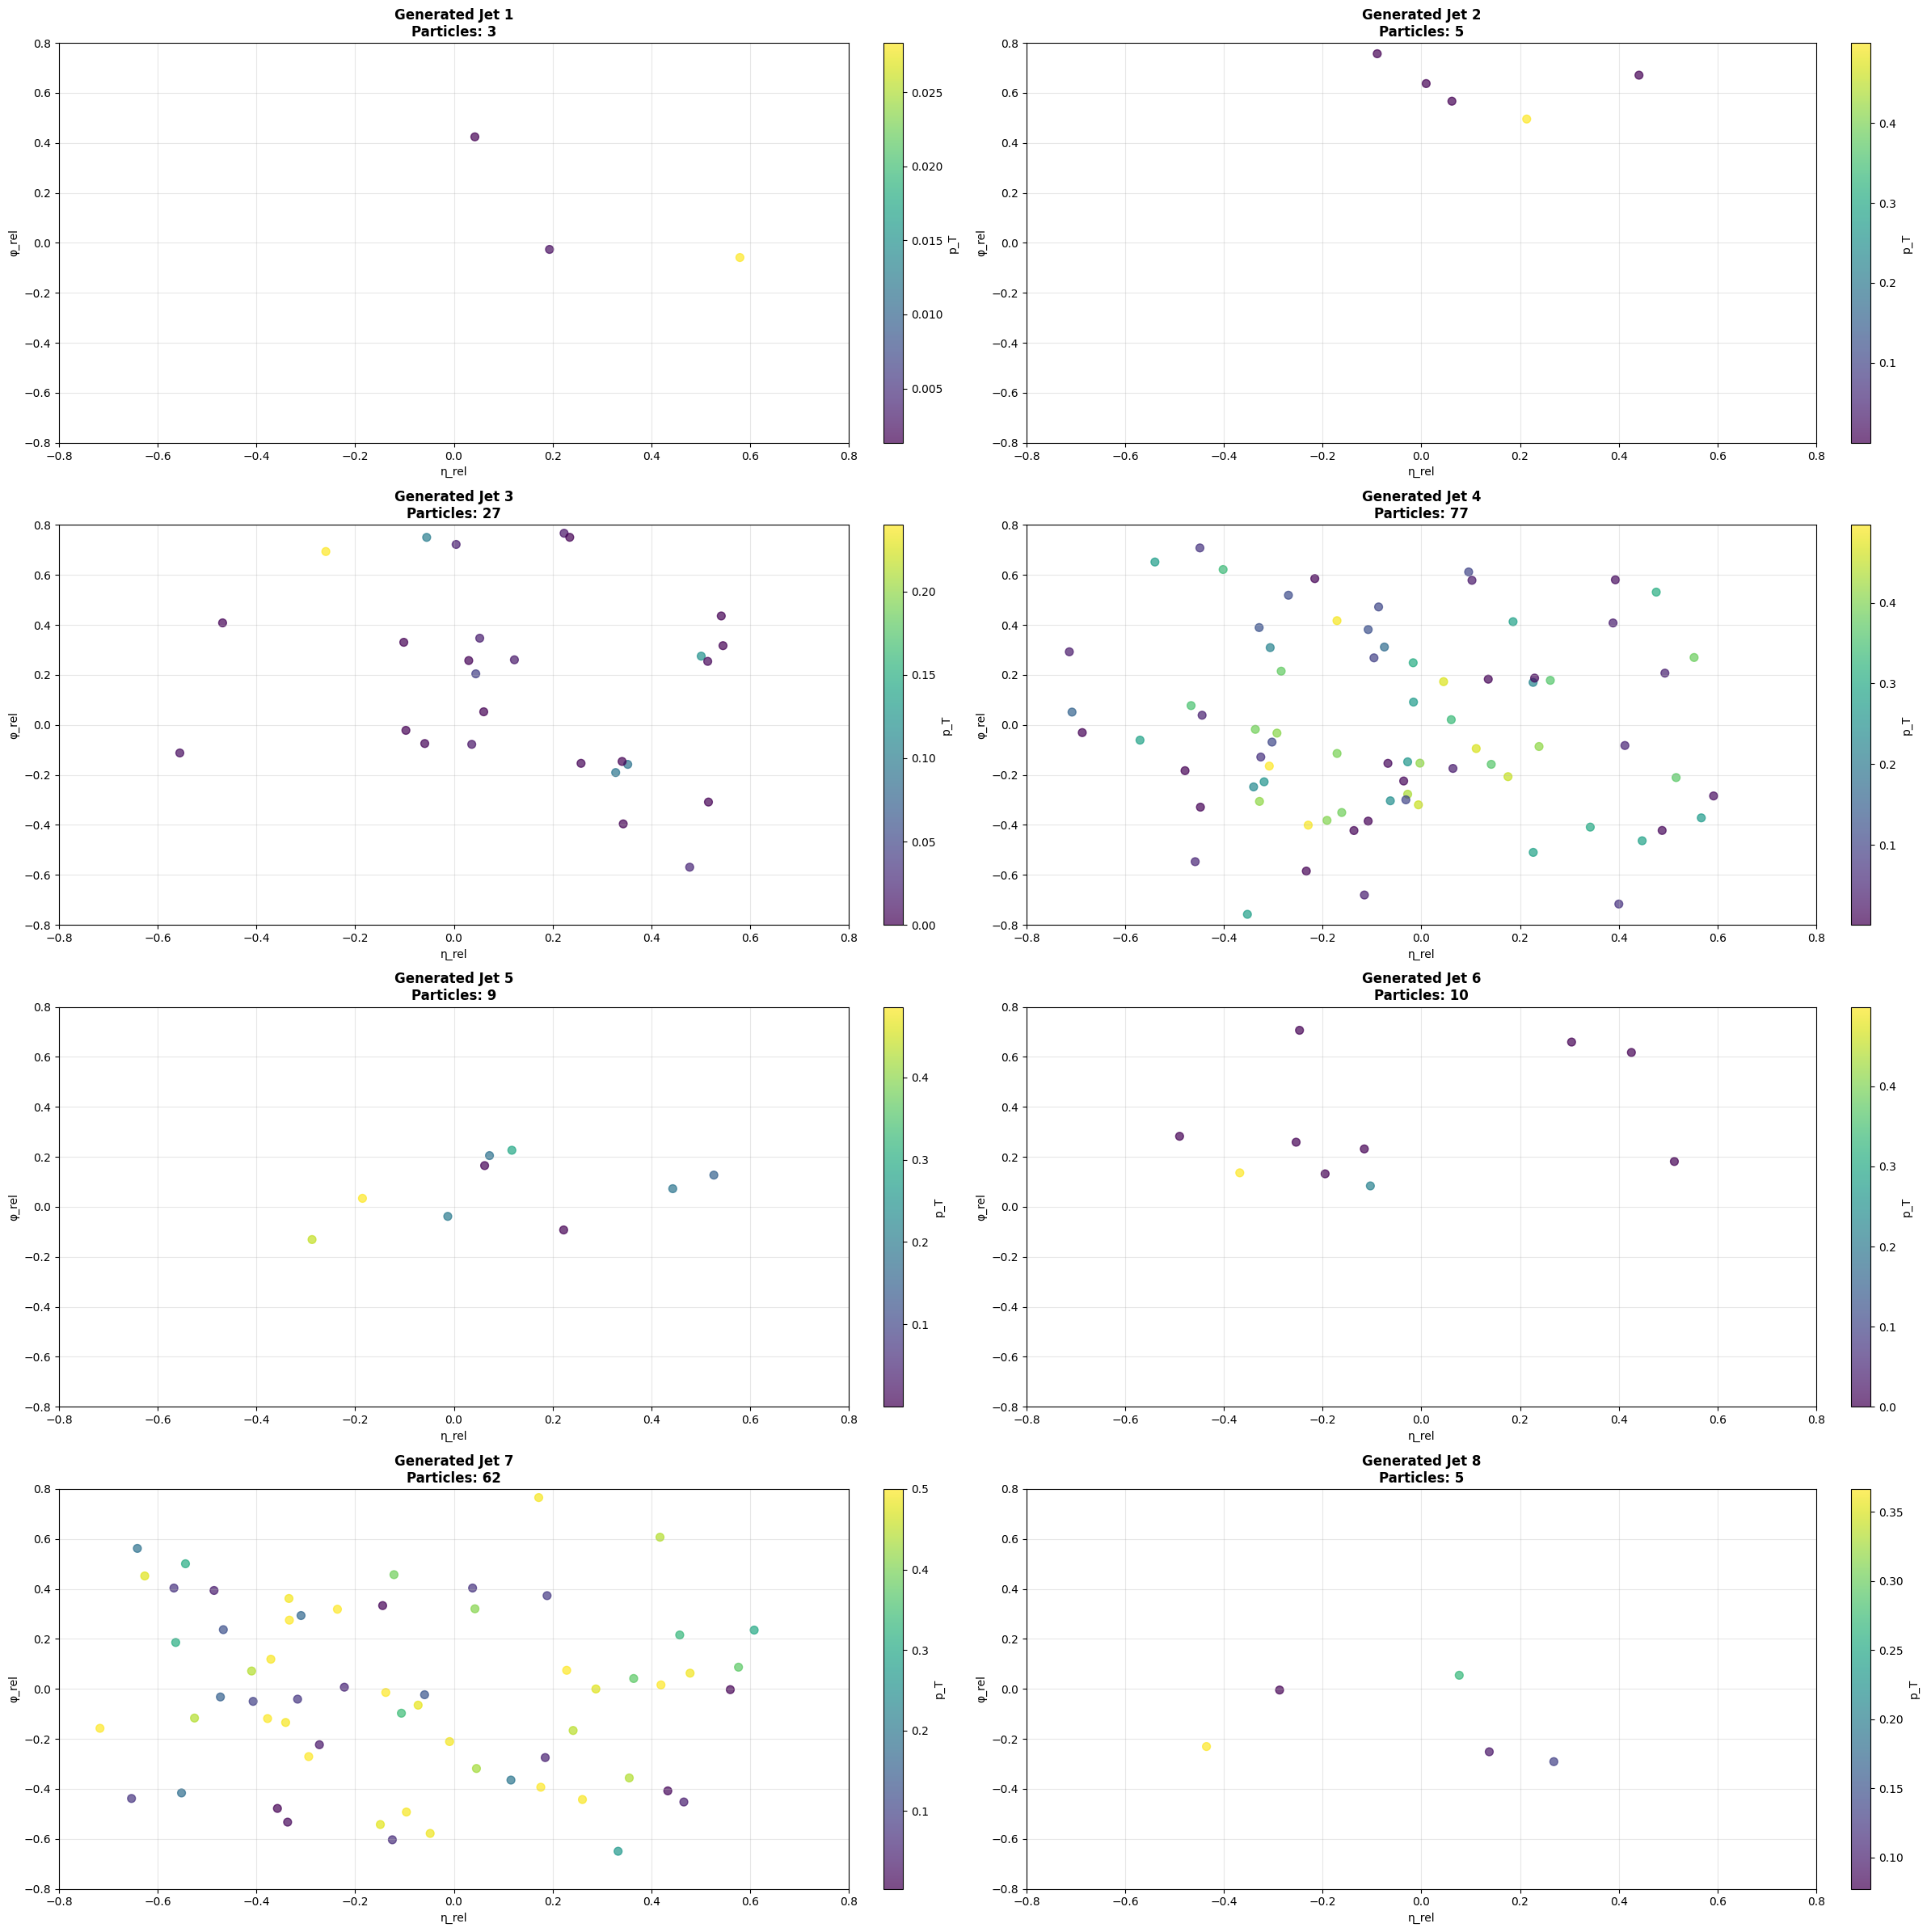


=== Particle decoder reconstruction comparison ===
Jet 1 Metrics:
Wasserstein η: 0.0096, φ: 0.0079, p_T: 0.0017
KL Divergence η: 10.1050, φ: 9.2769, p_T: 10.3231


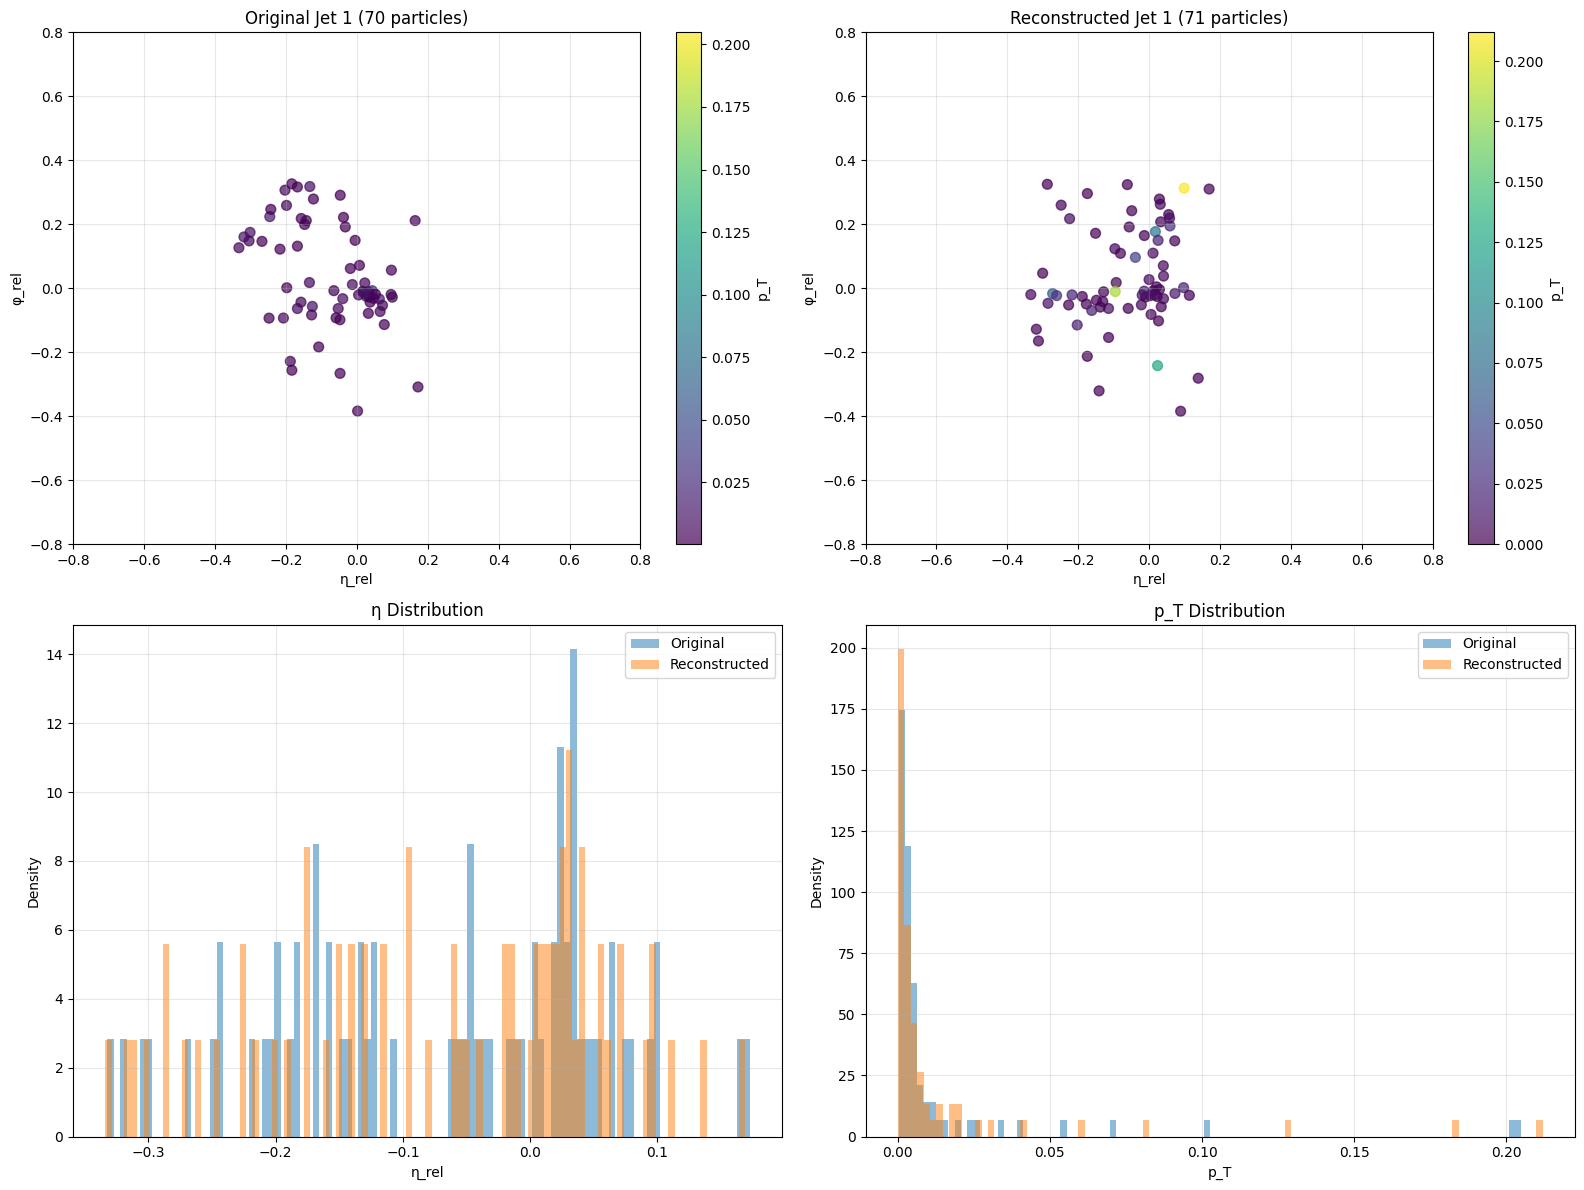

Jet 1 Statistics:
Original particles: 70
Reconstructed particles: 71
Original η range: [-0.332, 0.173]
Original p_T range: [0.000, 0.205]
Reconstructed η range: [-0.334, 0.169]
Reconstructed p_T range: [0.000, 0.212]

Jet 2 Metrics:
Wasserstein η: 0.0078, φ: 0.0072, p_T: 0.0013
KL Divergence η: 9.7577, φ: 9.4731, p_T: 8.2291


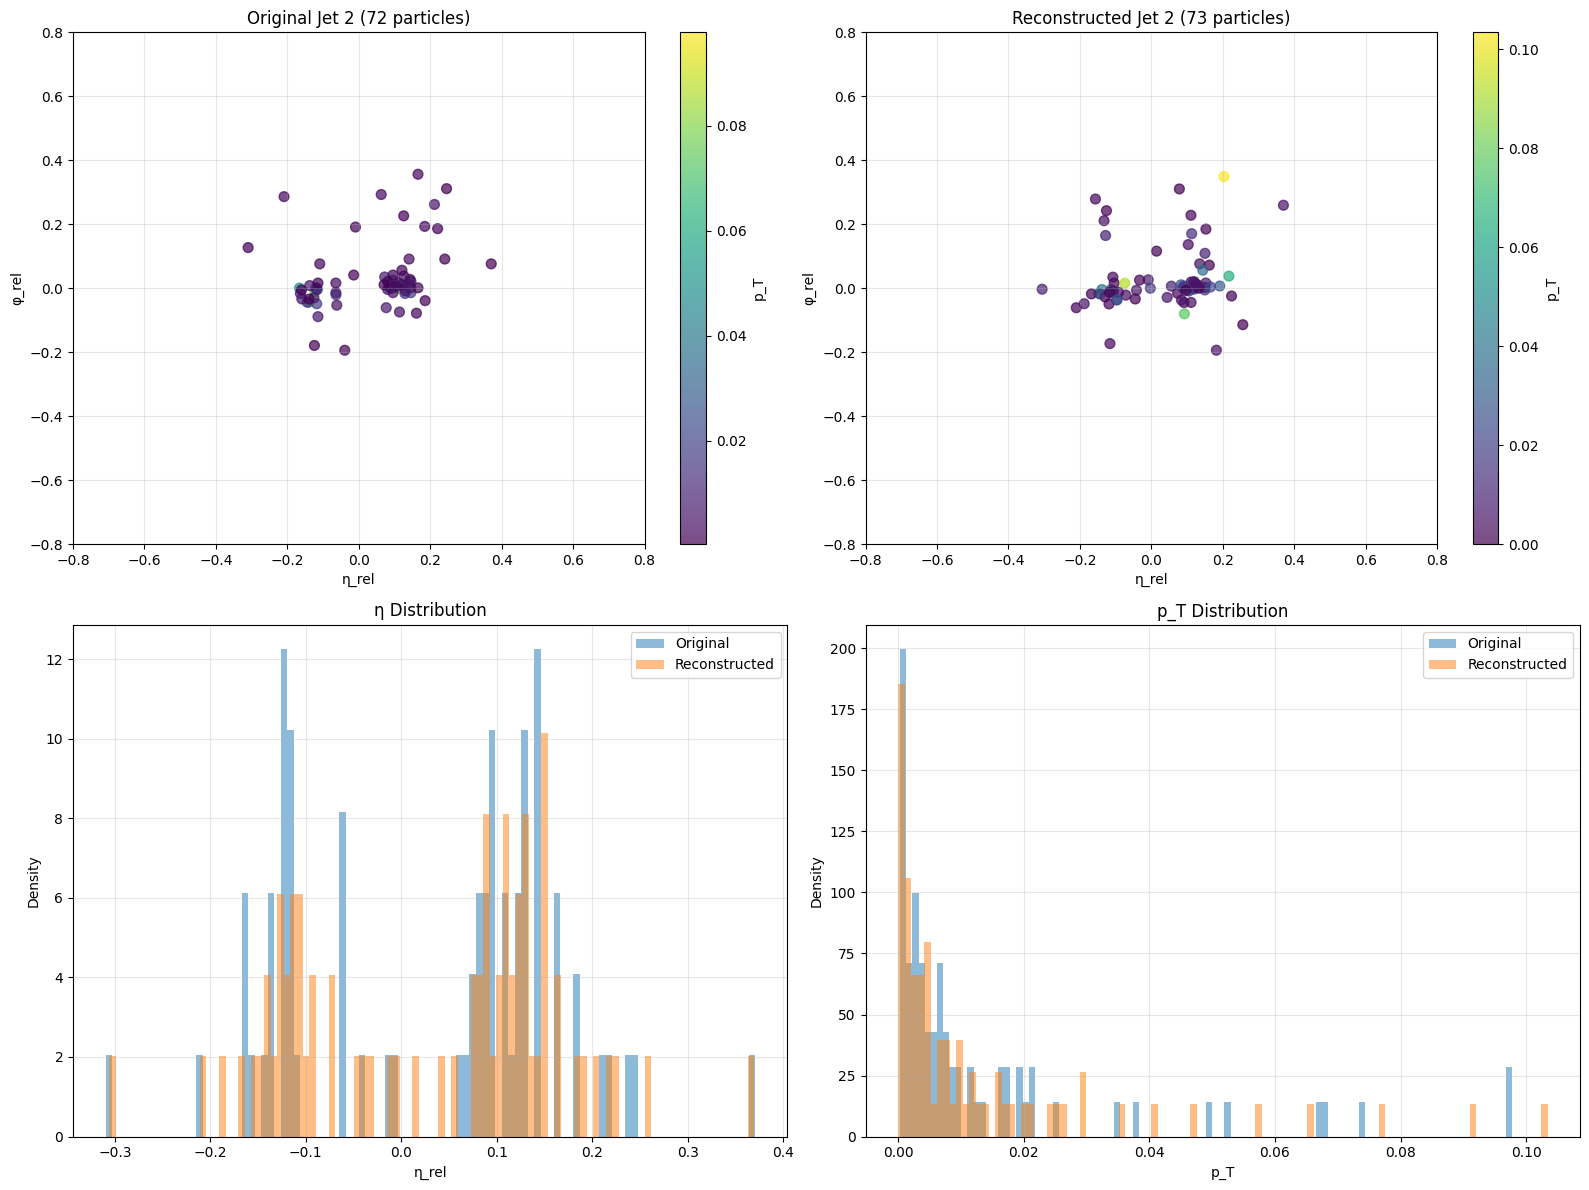

Jet 2 Statistics:
Original particles: 72
Reconstructed particles: 73
Original η range: [-0.310, 0.371]
Original p_T range: [0.000, 0.098]
Reconstructed η range: [-0.306, 0.370]
Reconstructed p_T range: [0.000, 0.103]

Jet 3 Metrics:
Wasserstein η: 0.0072, φ: 0.0089, p_T: 0.0018
KL Divergence η: 9.0877, φ: 9.3225, p_T: 11.0648


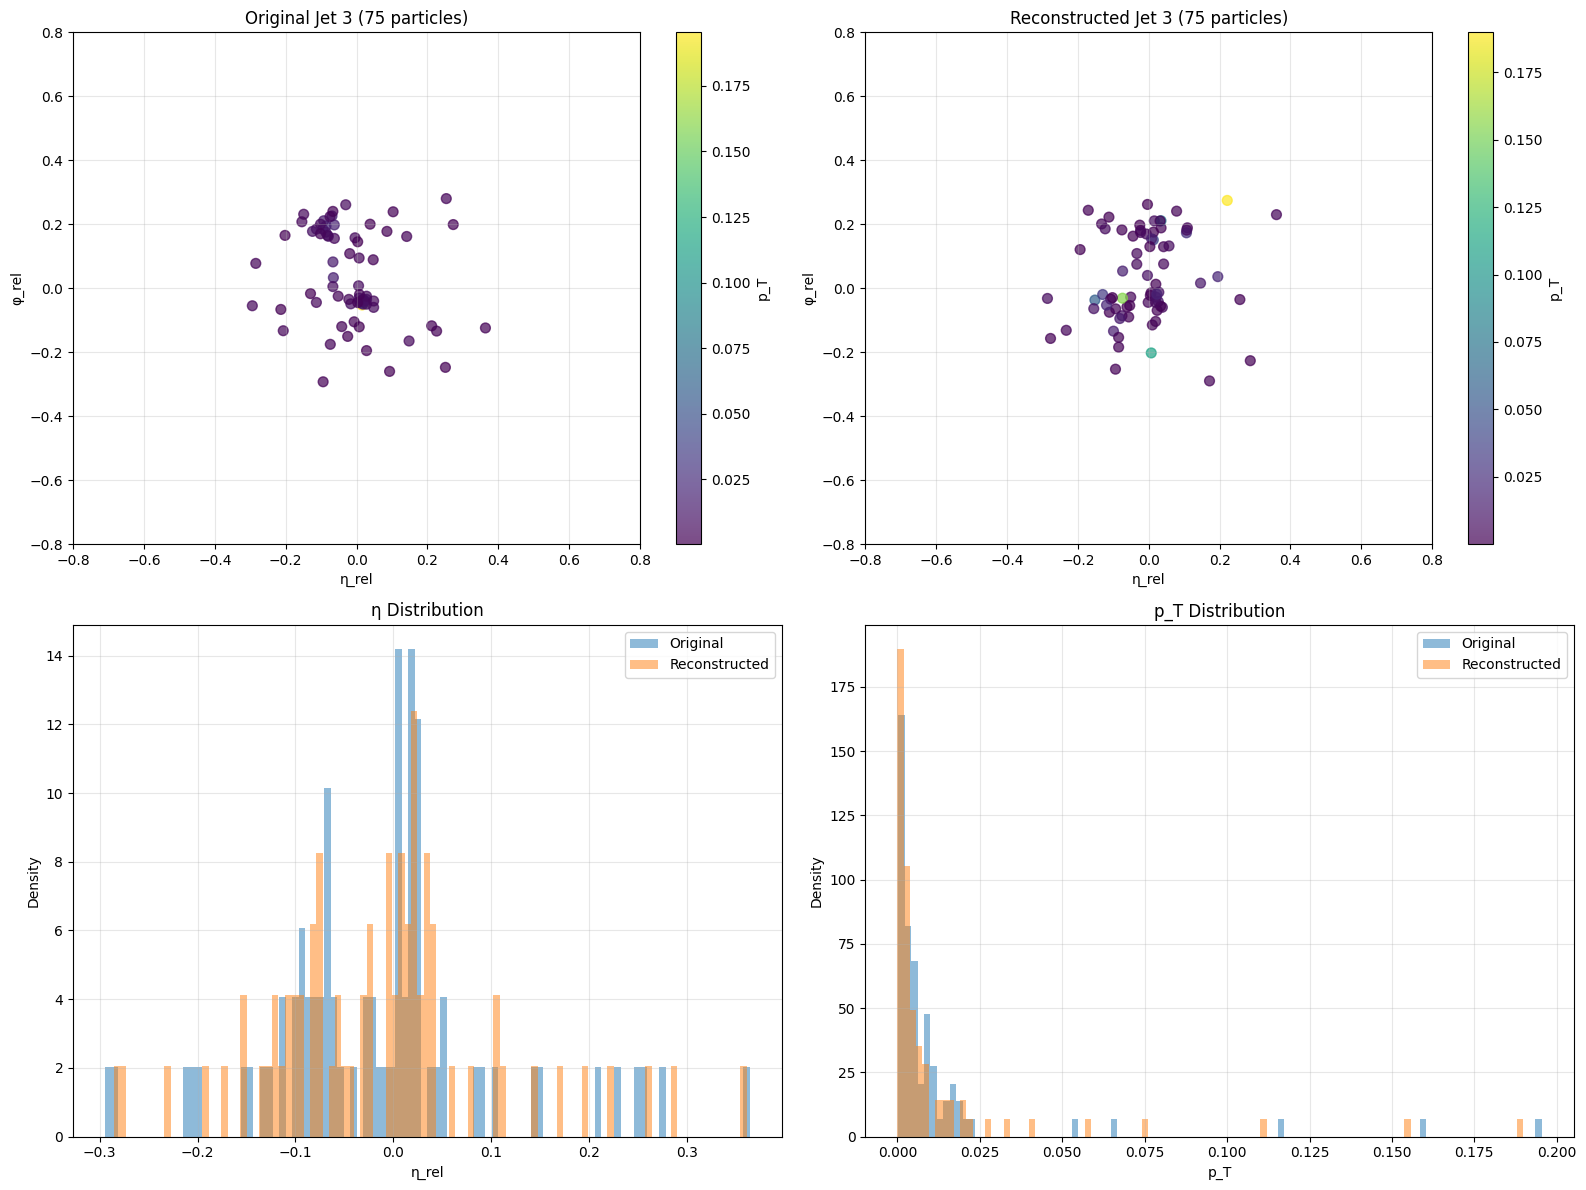

Jet 3 Statistics:
Original particles: 75
Reconstructed particles: 75
Original η range: [-0.294, 0.364]
Original p_T range: [0.000, 0.195]
Reconstructed η range: [-0.286, 0.360]
Reconstructed p_T range: [0.000, 0.190]


Component-wise Average Metrics (over comparisons):
Wasserstein - η: 0.0082, φ: 0.0080, p_T: 0.0016
KL Divergence - η: 9.6501, φ: 9.3575, p_T: 9.8723

=== Random real jets for comparison ===


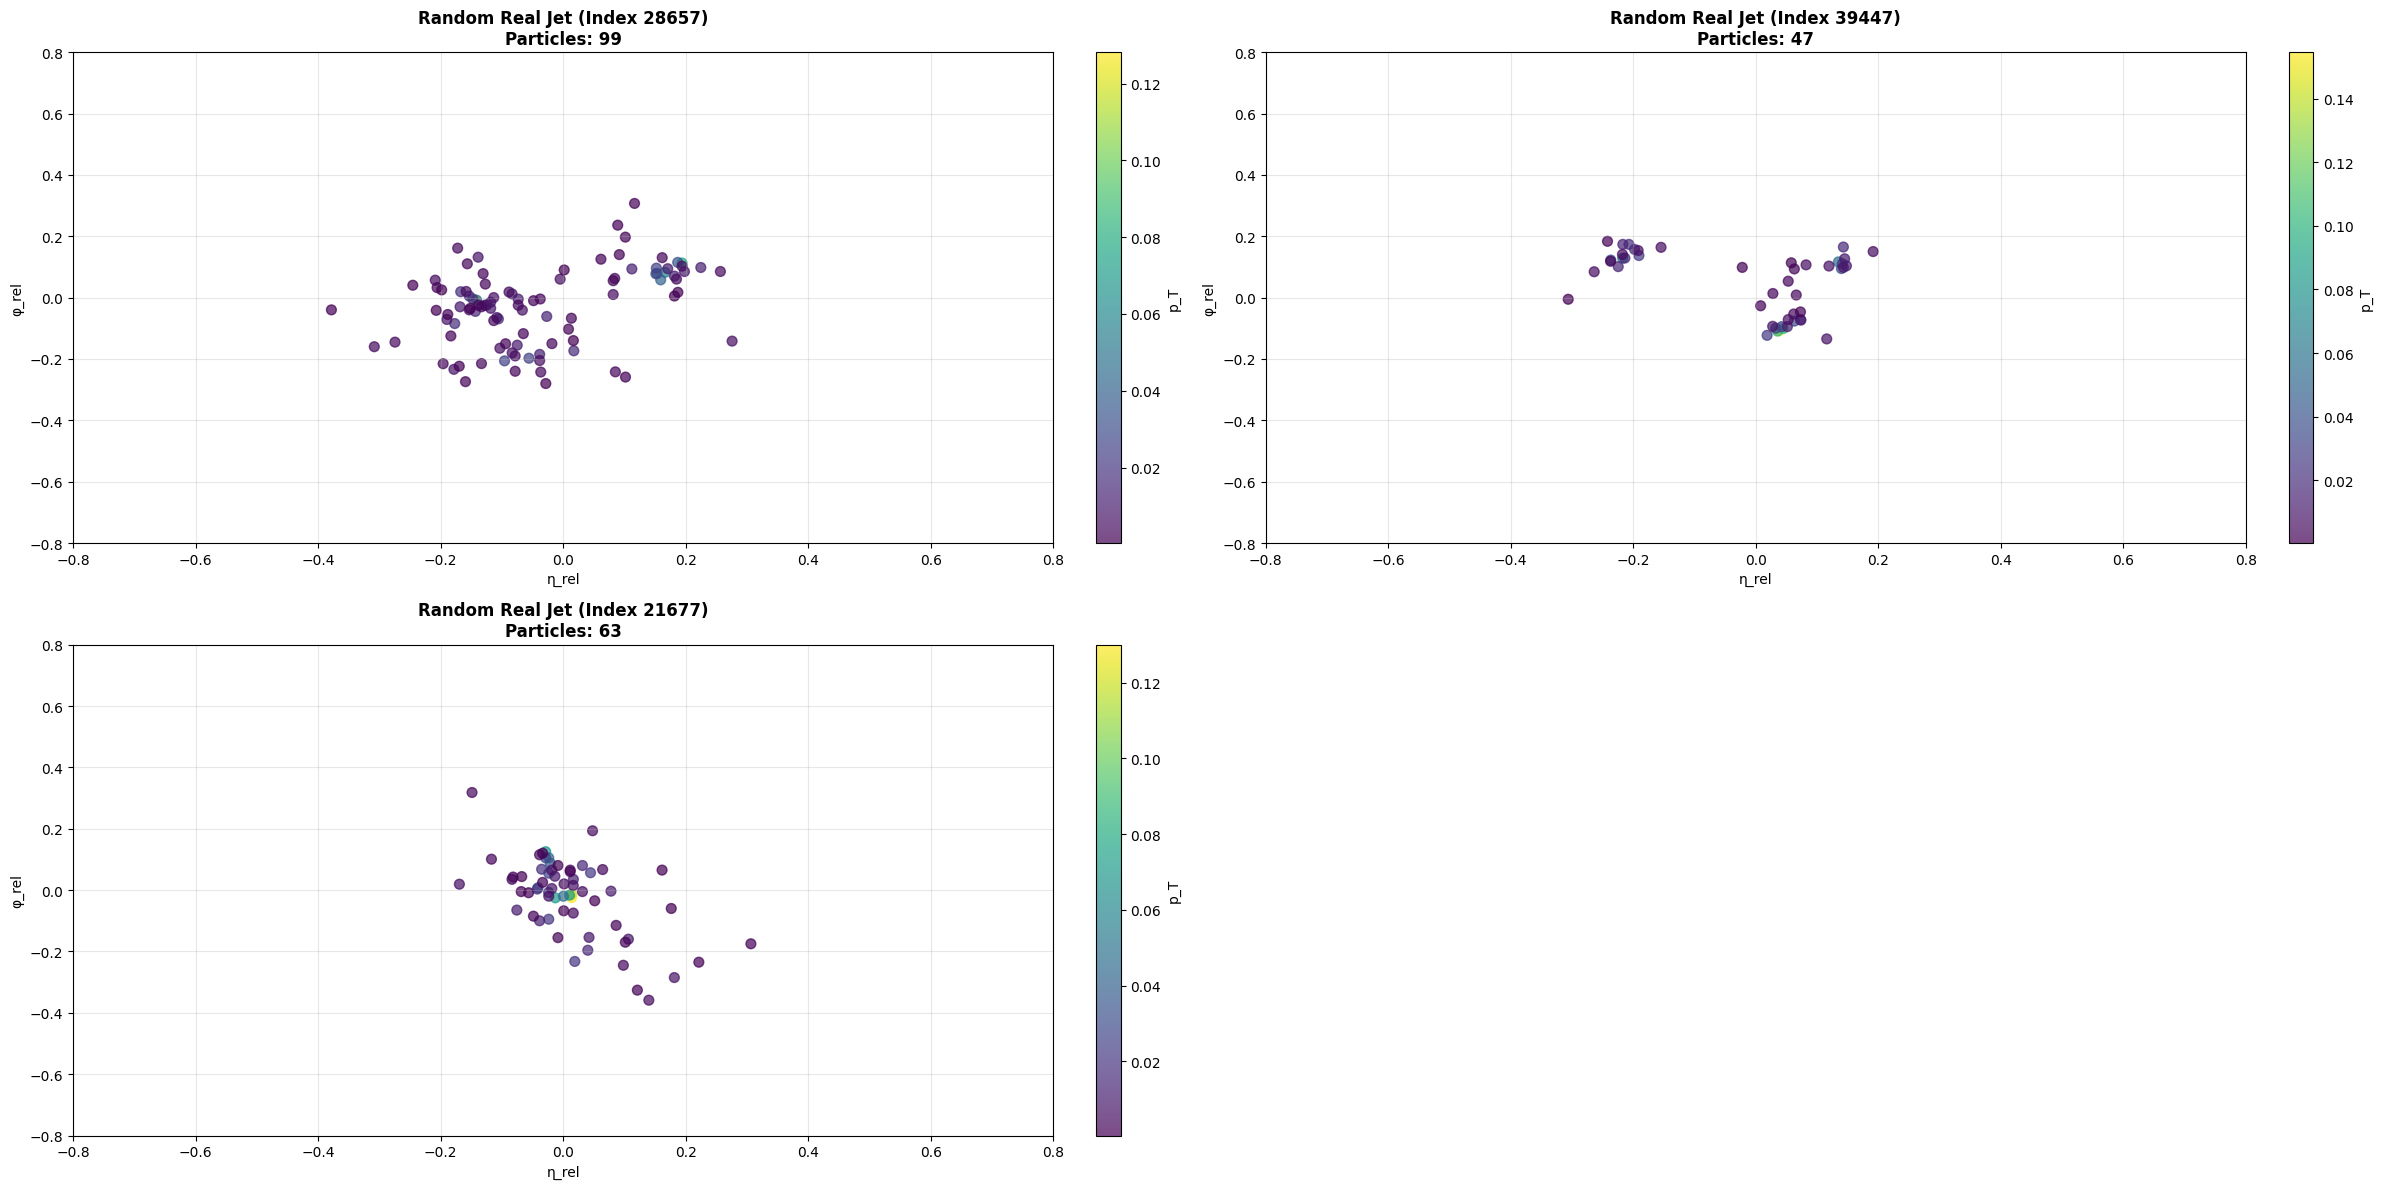


=== Summary ===
Total jets in dataset: 368113
Successfully processed: 50000
Processing success rate: 13.6%
Embedding dimension: 128
Generated samples: 8
Max particles per jet: 150
Batch size used for training: 8

JetNet pipeline completed successfully!

=== Generated Jet Analysis ===
Generated jets - Average particles: 24.75
Generated jets - Std particles: 27.02
Generated jets - Range: [3, 77]
Original jets - Average particles: 54.12
Original jets - Std particles: 19.68
Original jets - Range: [27, 75]


In [ ]:
# Install JetNet without cache to ensure clean install

# Restart runtime after installation (in Colab: Runtime -> Restart Runtime)
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Alternative: Use energyflow package if JetNet has compatibility issues
# !pip install energyflow
import math
import numpy as np
import matplotlib.pyplot as plt
from jetnet.datasets import JetNet
USE_JETNET = True
print("Using JetNet dataset")

import networkx as nx
from sklearn.neighbors import kneighbors_graph
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn import ChebConv, global_mean_pool, global_max_pool, global_add_pool  # Added global_add_pool
from torch_geometric.loader import DataLoader as GeometricDataLoader

from scipy.stats import wasserstein_distance, ks_2samp

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing ---

def load_jetnet_data():
    """Load JetNet dataset with fallback options"""
    global USE_JETNET

    if USE_JETNET is None:
        raise ImportError("No suitable dataset package available")

    if USE_JETNET:
        # Load JetNet data
        particle_data, jet_data = JetNet.getData(
            jet_type=['g', 'q', 't'],
            data_dir="jetnet_data",
            particle_features=['etarel', 'phirel', 'ptrel', 'mask'],
            jet_features=['pt', 'eta', 'mass', 'num_particles'],
            num_particles=150,
            split='train',
            download=True
        )

        print("Particle shape:", particle_data.shape)
        print("Jet shape:", jet_data.shape)
        print(f"Total number of jets in dataset: {len(particle_data)}")

        return particle_data, jet_data

def get_hits_from_jetnet(jet_particles, jet_info):
    """Extract hits from JetNet particle data"""
    # Get valid particles (mask == 1)
    valid_mask = jet_particles[:, 3] == 1
    valid_particles = jet_particles[valid_mask]

    if len(valid_particles) == 0:
        return None

    # Sort by descending pt_rel
    sorted_idx = np.argsort(-valid_particles[:, 2])
    valid_particles = valid_particles[sorted_idx]

    # Extract features
    eta = valid_particles[:, 0]  # etarel
    phi = valid_particles[:, 1]  # phirel
    pt = valid_particles[:, 2]   # ptrel

    # Create hits array: [eta, phi, pt]
    hits = np.column_stack((eta, phi, pt))

    return hits

def make_graph(hits):
    """Create graph from hits using k-nearest neighbors"""
    if len(hits) < 4:  # Need at least 4 points for k=4
        # Use smaller k for sparse jets
        k = min(len(hits) - 1, 2)
        if k <= 0:
            return None, hits, None
    else:
        k = 4

    coords = hits[:, :2]  # eta, phi coordinates
    adj_matrix = kneighbors_graph(coords, n_neighbors=k, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(adj_matrix)
    return G, hits, adj_matrix



def collect_graph_and_targets(particle_data, jet_data, max_jets=3200):
    """Collect graph data and targets for training"""
    graph_data = []
    target_particles = []
    original_jets = []
    failed_count = 0

    n_jets = min(len(particle_data), max_jets)
    print(f"Collecting data for {n_jets} jets...")

    for i in range(n_jets):
        if i % 100 == 0:
            print(f"Processing jet {i}/{n_jets}...")

        try:
            jet_particles = particle_data[i]
            jet_info = jet_data[i]

            hits = get_hits_from_jetnet(jet_particles, jet_info)
            if hits is None or len(hits) == 0:
                failed_count += 1
                continue

            G, hits, adj_matrix = make_graph(hits)
            if G is None or adj_matrix is None:
                failed_count += 1
                continue

            x = torch.tensor(hits, dtype=torch.float)
            edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)

            data = Data(x=x, edge_index=edge_index)
            graph_data.append(data)

            # Sort target particles by descending pt_rel and pad
            valid_mask = jet_particles[:, 3] == 1
            valid_particles = jet_particles[valid_mask]
            if len(valid_particles) > 0:
                sorted_idx = np.argsort(-valid_particles[:, 2])
                sorted_valid = valid_particles[sorted_idx]
            else:
                sorted_valid = np.empty((0, 4))
            padded = np.zeros((150, 4))
            padded[:len(sorted_valid)] = sorted_valid
            padded[:len(sorted_valid), 3] = 1  # set mask
            target_particles.append(torch.tensor(padded, dtype=torch.float))

            original_jets.append((jet_particles, jet_info))

        except Exception as e:
            print(f"Error processing jet {i}: {e}")
            failed_count += 1
            continue

    print(f"\nCollection complete!")
    print(f"Successfully collected: {len(graph_data)} jets")
    print(f"Failed: {failed_count} jets")

    return graph_data, target_particles, original_jets

# --- 2. Graph Neural Network Model ---

class SimpleChebNet(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=64, K=4, out_dim=32):
        super().__init__()
        self.conv1 = ChebConv(in_dim, hidden_dim, K)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K)
        self.conv3 = ChebConv(hidden_dim, hidden_dim, K)  # Added for depth
        self.conv4 = ChebConv(hidden_dim, out_dim, K)     # Added for depth
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)  # Added

    def forward(self, x, edge_index, batch=None):
        x = self.conv1(x, edge_index)
        x = self.bn1(F.leaky_relu(x))
        x = self.conv2(x, edge_index)
        x = self.bn2(F.leaky_relu(x))
        x = self.conv3(x, edge_index)
        x = self.bn3(F.leaky_relu(x))
        x = self.conv4(x, edge_index)
        x = F.normalize(x, p=2, dim=1)  # L2 normalize embeddings

        # MODIFIED: Concat mean, max, min, sum pooling
        if batch is None:
            mean_p = x.mean(dim=0)
            max_p = x.max(dim=0)[0]
            min_p = -(-x).max(dim=0)[0]  # Equivalent to min
            sum_p = x.sum(dim=0)
            pooled = torch.cat([mean_p, max_p, min_p, sum_p], dim=-1)
        else:
            mean_p = global_mean_pool(x, batch)
            max_p = global_max_pool(x, batch)
            min_p = -global_max_pool(-x, batch)
            sum_p = global_add_pool(x, batch)
            pooled = torch.cat([mean_p, max_p, min_p, sum_p], dim=1)

        return pooled  # Now dim=128 (out_dim*4)

# --- 3. Diffusion Model with Batching ---

class SimpleDiffusionMLP(nn.Module):
    def __init__(self, emb_dim, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim+1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, emb_dim)
        )

    def forward(self, x, t):
        # x: [batch, emb_dim], t: [batch, 1]
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

class DiffusionDataset(Dataset):
    def __init__(self, embeddings):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx]

def beta(t, beta_0=1e-4, beta_1=0.02):
    """Linear beta schedule"""
    return beta_0 + t * (beta_1 - beta_0)

def alpha_bar(t, beta_0=1e-4, beta_1=0.02):
    return torch.exp(-(beta_0 * t + 0.5 * (beta_1 - beta_0) * t * t))

def train_diffusion_model_batched(embeddings, n_steps=1000, epochs=200, batch_size=8):
    """Train diffusion model on embeddings with proper batching"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    emb_dim = embeddings.shape[1]
    model = SimpleDiffusionMLP(emb_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Create dataset and dataloader
    dataset = DiffusionDataset(embeddings)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True if device.type == 'cuda' else False
    )

    print(f"Training diffusion model with {len(embeddings)} embeddings...")
    print(f"Batch size: {batch_size}, Batches per epoch: {len(dataloader)}")

    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device, non_blocking=True)
            batch_size_actual = batch.size(0)

            # Random time steps for each sample in batch
            t = torch.rand((batch_size_actual, 1), device=device)
            sqrt_alpha_bar_t = torch.sqrt(alpha_bar(t)) #how much noise to mix with original signal-> signal retention coeffecient
            sqrt_1_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar(t)) #noise coefficient

            # Add noise
            noise = torch.randn_like(batch)
            noisy_data = batch * sqrt_alpha_bar_t + noise * sqrt_1_minus_alpha_bar_t  # linear noise schedule

            # Predict noise
            pred_noise = model(noisy_data, t)
            loss = ((pred_noise - noise)**2).mean()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            # Clear cache periodically
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()

        avg_loss = epoch_loss / num_batches
        if epoch % 10 == 0:
            print(f"Diffusion Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

        # Clear cache at end of epoch
        torch.cuda.empty_cache()

    return model

def sample_diffusion_model_batched(model, emb_dim, n_samples=10, n_steps=200, batch_size=8):  # Increased n_steps
    """Sample new embeddings from trained diffusion model with batching using deterministic DDIM"""
    device = next(model.parameters()).device
    model.eval()

    all_samples = []

    with torch.no_grad():
        # Process samples in batches
        for i in range(0, n_samples, batch_size):
            current_batch_size = min(batch_size, n_samples - i)
            x = torch.randn((current_batch_size, emb_dim), device=device)

            # DDIM sampling loop (deterministic, eta=0, approximates probability flow ODE)
            for step in range(n_steps, 0, -1):
                t_value = step / n_steps
                s_value = (step - 1) / n_steps
                t = torch.full((current_batch_size, 1), t_value, device=device)
                alpha_t = alpha_bar(t)
                alpha_s = alpha_bar(torch.full((current_batch_size, 1), s_value, device=device))
                noise_pred = model(x, t)

                # DDIM formula (deterministic)
                sqrt_alpha_t = torch.sqrt(alpha_t)
                sqrt_alpha_s = torch.sqrt(alpha_s)
                sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t)
                sqrt_one_minus_alpha_s = torch.sqrt(1 - alpha_s)

                pred_x0 = (x - sqrt_one_minus_alpha_t * noise_pred) / sqrt_alpha_t
                x = sqrt_alpha_s * pred_x0 + sqrt_one_minus_alpha_s * noise_pred  # No sigma/noise term for deterministic

            all_samples.append(x.cpu().numpy())

    # Concatenate all batches
    return np.concatenate(all_samples, axis=0)

# --- 4. Enhanced Decoder Model for Particle Generation ---

class JetGraphDataset(Dataset):
    def __init__(self, graph_data, target_particles):
        self.graph_data = graph_data
        self.target_particles = target_particles

    def __len__(self):
        return len(self.graph_data)

    def __getitem__(self, idx):
        return self.graph_data[idx], self.target_particles[idx]

def collate_fn(batch):
    graphs = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    batched_graph = Batch.from_data_list(graphs)
    batched_targets = torch.stack(targets)
    return batched_graph, batched_targets

class ParticleDecoder(nn.Module):
    def __init__(self, emb_dim, max_particles=150, particle_dim=4, hidden_dims=[512, 1024]):  # MODIFIED: Increased hidden dims for more capacity
        super().__init__()
        self.max_particles = max_particles
        self.particle_dim = particle_dim
        self.output_size = max_particles * particle_dim

        # Build progressive layers
        layers = []
        current_dim = emb_dim

        # Input projection
        layers.extend([
            nn.Linear(current_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        ])
        current_dim = hidden_dims[0]

        # Expansion layer
        layers.extend([
            nn.Linear(current_dim, hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1)
        ])
        current_dim = hidden_dims[1]

        # Output layer
        layers.extend([
            nn.Linear(current_dim, self.output_size)
        ])

        self.main_net = nn.Sequential(*layers)

        # Residual connection
        self.residual_projection = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, self.output_size)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

    def forward(self, z):
        # Main path
        main_out = self.main_net(z)

        # Residual path
        residual_out = self.residual_projection(z)

        # Combine
        combined = main_out + 0.1 * residual_out

        # Reshape to particle format
        output = combined.view(-1, self.max_particles, self.particle_dim)

        # Apply appropriate activations
        # etarel, phirel can be negative, ptrel should be positive, mask should be 0-1
        eta = torch.tanh(output[:, :, 0]) * 0.8  # Scale to data range ~(-0.8, 0.8)
        phi = torch.tanh(output[:, :, 1]) * 0.8  # Scale to data range ~(-0.8, 0.8)

        # --- NEW p_T ACTIVATION ---
        # Map to [0, 0.5], which better covers your data's p_T range
        pt = torch.sigmoid(output[:, :, 2]) * 0.5   # Removed *0.1 for proper scaling

        # Better mask activation with temperature
        mask_logits = output[:, :, 3]
        mask = torch.sigmoid(mask_logits * 2.0)  # Higher temperature for sharper decisions

        output = torch.stack([eta, phi, pt, mask], dim=2)
        return output

def masked_wasserstein_loss(pred_particles, target_particles):
    """
    Calculates the 1-Wasserstein loss (approximated by L1 on sorted vectors)
    for eta, phi, and pt, using masks.

    This function is IMMUNE to padded [0,0,0] values.
    """
    # Get features and masks
    pred_eta = pred_particles[:, :, 0]
    pred_phi = pred_particles[:, :, 1]
    pred_pt = pred_particles[:, :, 2]
    pred_mask = pred_particles[:, :, 3] # Soft mask [B, 150]

    target_eta = target_particles[:, :, 0]
    target_phi = target_particles[:, :, 1]
    target_pt = target_particles[:, :, 2]
    target_mask = (target_particles[:, :, 3] > 0.5).float() # Binary mask [B, 150]

    # --- This is the key insight ---
    # We multiply the features by their masks.
    # All padded particles (where target_mask=0) will have their features set to 0.
    # All "fake" predicted particles (where pred_mask is low) will have features near 0.

    pred_eta_masked = pred_eta * pred_mask
    pred_phi_masked = pred_phi * pred_mask
    pred_pt_masked = pred_pt * pred_mask

    target_eta_masked = target_eta * target_mask
    target_phi_masked = target_phi * target_mask
    target_pt_masked = target_pt * target_mask

    # Sort the masked features along the particle dimension (dim=1)
    # All the 0-valued padded particles will be sorted to one end of the list.
    pred_eta_sorted, _ = torch.sort(pred_eta_masked, dim=1)
    pred_phi_sorted, _ = torch.sort(pred_phi_masked, dim=1)
    pred_pt_sorted, _ = torch.sort(pred_pt_masked, dim=1)

    target_eta_sorted, _ = torch.sort(target_eta_masked, dim=1)
    target_phi_sorted, _ = torch.sort(target_phi_masked, dim=1)
    target_pt_sorted, _ = torch.sort(target_pt_masked, dim=1)

    # Calculate L1 loss (which approximates 1-Wasserstein)
    # The loss for the 0-padded particles will be 0-vs-0, which is 0.
    # The loss is ONLY driven by the non-zero (real) particles!
    loss_fn = nn.L1Loss()
    w_loss_eta = loss_fn(pred_eta_sorted, target_eta_sorted)
    w_loss_phi = loss_fn(pred_phi_sorted, target_phi_sorted)
    w_loss_pt = loss_fn(pred_pt_sorted, target_pt_sorted)

    return w_loss_eta + w_loss_phi + w_loss_pt

def train_autoencoder(gnn, decoder, graph_data, target_particles, epochs=300, batch_size=8):  # Increased epochs
    """Train GNN and decoder jointly as autoencoder"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training autoencoder on device: {device}")

    # Dataset and loader
    dataset = JetGraphDataset(graph_data, target_particles)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True if device.type == 'cuda' else False)

    # Optimizer and scheduler
    optimizer = optim.AdamW(list(gnn.parameters()) + list(decoder.parameters()), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs//4, eta_min=1e-6)

    # Loss functions
    mse_criterion = nn.MSELoss()
    bce_criterion = nn.BCELoss()

    print(f"Training autoencoder with {len(dataset)} samples, batch size {batch_size}")
    print(f"Total parameters: {sum(p.numel() for p in gnn.parameters()) + sum(p.numel() for p in decoder.parameters()):,}")

    gnn.train()
    decoder.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for batch_idx, (batch_graph, batch_target) in enumerate(loader):
            batch_graph = batch_graph.to(device)
            batch_target = batch_target.to(device)

            # Forward through GNN and pool (MODIFIED pooling is handled in GNN forward)
            pooled = gnn(batch_graph.x, batch_graph.edge_index, batch_graph.batch)

            # Decode
            pred = decoder(pooled)

            # Losses (increased eta and phi loss weights to improve their reconstructions and EMD)
            particle_loss = masked_wasserstein_loss(pred, batch_target)
            mask_loss = bce_criterion(pred[:, :, 3], batch_target[:, :, 3])
            target_num = torch.sum(batch_target[:, :, 3], dim=1)
            pred_num = torch.sum(pred[:, :, 3], dim=1)
            count_loss = nn.MSELoss()(pred_num, target_num)
            loss = particle_loss * 100.0 + mask_loss * 2.0 + count_loss * 0.01
            if(epoch%10==0):
              print(f"Particle loss: {100*particle_loss:.4f}, Mask loss: {2*mask_loss:.4f}, Count loss: {0.001*count_loss:.4f}")


            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(gnn.parameters()) + list(decoder.parameters()), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            if batch_idx % 5 == 0:
                torch.cuda.empty_cache()

        avg_loss = epoch_loss / num_batches

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        new_lr = optimizer.param_groups[0]['lr']
        if old_lr != new_lr:
            print(f"  Learning rate reduced from {old_lr:.8f} to {new_lr:.8f}")

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 10 == 0:
            print(f"Autoencoder Epoch {epoch}/{epochs}")
            print(f"  Loss: {avg_loss:.6f}")
            print(f"  LR: {optimizer.param_groups[0]['lr']:.8f}")
            print(f"  Best Loss: {best_loss:.6f}, Patience: {patience_counter}")

        if patience_counter >= 15:
            print(f"Early stopping at epoch {epoch}")
            break

        torch.cuda.empty_cache()

    return gnn, decoder

# --- 5. Visualization Functions ---

def visualize_particle_jets(particle_data_list, titles, n_cols=2):
    """Visualize jets as scatter plots using particle data"""
    n_jets = len(particle_data_list)
    n_rows = (n_jets + n_cols - 1) // n_cols

    plt.style.use('default')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))
    fig.patch.set_facecolor('white')

    # Handle single row case
    if n_rows == 1:
        axes = axes.reshape(1, -1) if n_cols > 1 else [axes]
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, (particles, title) in enumerate(zip(particle_data_list, titles)):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        # Get valid particles
        valid_mask = particles[:, 3] > 0.5  # Use threshold for mask
        if valid_mask.sum() == 0:
            ax.text(0.5, 0.5, 'No valid particles', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title, fontsize=12, fontweight='bold')
            continue

        valid_particles = particles[valid_mask]
        eta = valid_particles[:, 0]
        phi = valid_particles[:, 1]
        pt = valid_particles[:, 2]

        # Create scatter plot
        scatter = ax.scatter(eta, phi, c=pt, s=50, cmap='viridis', alpha=0.7)

        ax.set_title(f"{title}\nParticles: {len(valid_particles)}", fontsize=12, fontweight='bold')
        ax.set_xlabel('η_rel', fontsize=10)
        ax.set_ylabel('φ_rel', fontsize=10)
        ax.grid(True, alpha=0.3)

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('p_T', fontsize=10)

        # Set reasonable axis limits
        ax.set_xlim(-0.8, 0.8)
        ax.set_ylim(-0.8, 0.8)

    # Hide unused subplots
    for i in range(n_jets, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

def calculate_kl_divergence(real_data, generated_data, n_bins=100):
    """
    KL divergence following the paper's methodology exactly
    """
    # Remove invalid values
    real_data = real_data[np.isfinite(real_data)]
    generated_data = generated_data[np.isfinite(generated_data)]

    if len(real_data) == 0 or len(generated_data) == 0:
        return float('inf')

    # PAPER'S METHOD: Equiprobable quantile binning from target distribution
    min_val, max_val = real_data.min(), real_data.max()

    generated_data_clipped = np.clip(generated_data, min_val, max_val)

    bin_edges = np.quantile(real_data, np.linspace(0, 1, n_bins + 1))
    bin_edges[0] -= 1e-10
    bin_edges[-1] += 1e-10

    # Calculate histograms
    real_hist, _ = np.histogram(real_data, bins=bin_edges)
    gen_hist, _ = np.histogram(generated_data_clipped, bins=bin_edges)

    # Convert to probabilities
    real_prob = real_hist / real_hist.sum()
    gen_prob = gen_hist / gen_hist.sum()

    # Add epsilon and calculate KL
    epsilon = 1e-10
    real_prob = np.maximum(real_prob, epsilon)
    gen_prob = np.maximum(gen_prob, epsilon)

    kl_div = np.sum(real_prob * np.log(real_prob / gen_prob))
    return kl_div

def compare_particle_reconstruction(original_particles, reconstructed_particles, idx):
    """Compare original and reconstructed particle data"""
    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.patch.set_facecolor('white')

    # Original particles
    orig_valid = original_particles[:, 3] == 1
    if orig_valid.sum() > 0:
        orig_valid_particles = original_particles[orig_valid]
        scatter1 = ax1.scatter(orig_valid_particles[:, 0], orig_valid_particles[:, 1],
                             c=orig_valid_particles[:, 2], s=50, cmap='viridis', alpha=0.7)
        ax1.set_title(f'Original Jet {idx+1} ({orig_valid.sum()} particles)')
        ax1.set_xlabel('η_rel')
        ax1.set_ylabel('φ_rel')
        ax1.set_xlim(-0.8, 0.8)
        ax1.set_ylim(-0.8, 0.8)
        ax1.grid(True, alpha=0.3)
        plt.colorbar(scatter1, ax=ax1, label='p_T')

    # Reconstructed particles
    recon_valid = reconstructed_particles[:, 3] > 0.5
    if recon_valid.sum() > 0:
        recon_valid_particles = reconstructed_particles[recon_valid]
        scatter2 = ax2.scatter(recon_valid_particles[:, 0], recon_valid_particles[:, 1],
                             c=recon_valid_particles[:, 2], s=50, cmap='viridis', alpha=0.7)
        ax2.set_title(f'Reconstructed Jet {idx+1} ({recon_valid.sum()} particles)')
        ax2.set_xlabel('η_rel')
        ax2.set_ylabel('φ_rel')
        ax2.set_xlim(-0.8, 0.8)
        ax2.set_ylim(-0.8, 0.8)
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter2, ax=ax2, label='p_T')

    # Feature distributions
    if orig_valid.sum() > 0 and recon_valid.sum() > 0:
        orig_valid_particles = original_particles[orig_valid]
        recon_valid_particles = reconstructed_particles[recon_valid]
        # η distribution
        ax3.hist(orig_valid_particles[:, 0], bins=100, alpha=0.5, label='Original', density=True)
        ax3.hist(recon_valid_particles[:, 0], bins=100, alpha=0.5, label='Reconstructed', density=True)
        ax3.set_xlabel('η_rel')
        ax3.set_ylabel('Density')
        ax3.set_title('η Distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # p_T distribution
        ax4.hist(orig_valid_particles[:, 2], bins=100, alpha=0.5, label='Original', density=True)
        ax4.hist(recon_valid_particles[:, 2], bins=100, alpha=0.5, label='Reconstructed', density=True)
        ax4.set_xlabel('p_T')
        ax4.set_ylabel('Density')
        ax4.set_title('p_T Distribution')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ws_eta = wasserstein_distance(orig_valid_particles[:, 0], recon_valid_particles[:, 0])
        ws_phi = wasserstein_distance(orig_valid_particles[:, 1], recon_valid_particles[:, 1])
        ws_pt = wasserstein_distance(orig_valid_particles[:, 2], recon_valid_particles[:, 2])
        kl_eta = calculate_kl_divergence(orig_valid_particles[:, 0], recon_valid_particles[:, 0])
        kl_phi = calculate_kl_divergence(orig_valid_particles[:, 1], recon_valid_particles[:, 1])
        kl_pt = calculate_kl_divergence(orig_valid_particles[:, 2], recon_valid_particles[:, 2])


        print(f"Jet {idx+1} Metrics:")
        print(f"Wasserstein η: {ws_eta:.4f}, φ: {ws_phi:.4f}, p_T: {ws_pt:.4f}")
        print(f"KL Divergence η: {kl_eta:.4f}, φ: {kl_phi:.4f}, p_T: {kl_pt:.4f}")

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Jet {idx+1} Statistics:")
    print(f"Original particles: {orig_valid.sum()}")
    print(f"Reconstructed particles: {recon_valid.sum()}")
    if orig_valid.sum() > 0:
        print(f"Original η range: [{orig_valid_particles[:, 0].min():.3f}, {orig_valid_particles[:, 0].max():.3f}]")
        print(f"Original p_T range: [{orig_valid_particles[:, 2].min():.3f}, {orig_valid_particles[:, 2].max():.3f}]")
    if recon_valid.sum() > 0:
        print(f"Reconstructed η range: [{recon_valid_particles[:, 0].min():.3f}, {recon_valid_particles[:, 0].max():.3f}]")
        print(f"Reconstructed p_T range: [{recon_valid_particles[:, 2].min():.3f}, {recon_valid_particles[:, 2].max():.3f}]")
    print()

# --- 6. Main Pipeline with JetNet Data ---

def main_pipeline_jetnet(batch_size=8):
    """Main pipeline using JetNet dataset"""

    # 1. Load JetNet data
    print("=== Loading JetNet data ===")
    particle_data, jet_data = load_jetnet_data()

    # 2. Collect graph data and targets
    print("\n=== Collecting graph data ===")
    graph_data, target_particles, original_jets = collect_graph_and_targets(particle_data, jet_data, max_jets=50000)

    if len(graph_data) == 0:
        print("No jets were successfully collected!")
        return None

    # 3. Initialize and train autoencoder (GNN + decoder)
    print("\n=== Training autoencoder ===")
    gnn = SimpleChebNet(in_dim=3, hidden_dim=64, K=4, out_dim=32).to(device)  # out_dim=32, but pooled=128 after concat
    decoder = ParticleDecoder(emb_dim=128).to(device)  # MODIFIED: emb_dim=128 to match expanded pooling
    gnn, decoder = train_autoencoder(gnn, decoder, graph_data, target_particles, epochs=300, batch_size=batch_size)

    # 4. Extract pooled embeddings using trained GNN
    print("\n=== Extracting pooled embeddings ===")
    gnn.eval()
    all_pooled_embeddings = []
    for data in graph_data:
        data = data.to(device)
        with torch.no_grad():
            pooled = gnn(data.x, data.edge_index).cpu().numpy()  # MODIFIED: No batch, but forward handles it
        all_pooled_embeddings.append(pooled)
    all_pooled_embeddings = np.stack(all_pooled_embeddings)

    # 5. Train diffusion model
    print(f"\n=== Training diffusion model (batch_size={batch_size}) ===")
    diff_model = train_diffusion_model_batched(
        all_pooled_embeddings, epochs=200, batch_size=batch_size
    )

    # 6. Generate new samples
    print("\n=== Generating new samples ===")
    n_samples = 25000
    new_embeddings = sample_diffusion_model_batched(
        diff_model, emb_dim=all_pooled_embeddings.shape[1],
        n_samples=n_samples, batch_size=batch_size
    )

    decoder.eval()
    with torch.no_grad():
        # Generate particles from embeddings
        generated_particles = []
        for i in range(0, len(new_embeddings), batch_size):
            batch_embeddings = new_embeddings[i:i+batch_size]
            batch_embeddings_torch = torch.tensor(batch_embeddings, dtype=torch.float32).to(device)
            batch_particles = decoder(batch_embeddings_torch).cpu().numpy()
            generated_particles.append(batch_particles)

        generated_particles = np.concatenate(generated_particles, axis=0)

    # 7. Visualize generated jets
    print(f"\n=== Visualizing {n_samples} generated jets ===")
    titles = [f'Generated Jet {i+1}' for i in range(n_samples)]
    visualize_particle_jets(generated_particles, titles)

    # 8. Compare decoder reconstructions
    print("\n=== Particle decoder reconstruction comparison ===")
    n_compare = min(3, len(all_pooled_embeddings))
    comparison_embeddings = all_pooled_embeddings[:n_compare]

    with torch.no_grad():
        comparison_embeddings_torch = torch.tensor(comparison_embeddings, dtype=torch.float32).to(device)
        decoder_reconstructions = decoder(comparison_embeddings_torch).cpu().numpy()

    for i in range(n_compare):
        original_particles, _ = original_jets[i]
        decoder_reconstruction = decoder_reconstructions[i]
        compare_particle_reconstruction(original_particles, decoder_reconstruction, i)

    # Fixed metrics loop to n_compare
    ws_eta_list, ws_phi_list, ws_pt_list = [], [], []
    kl_eta_list, kl_phi_list, kl_pt_list = [], [], []

    for i in range(n_compare):
        original_particles, _ = original_jets[i]
        decoder_reconstruction = decoder_reconstructions[i]
        orig_valid = original_particles[:, 3] == 1
        recon_valid = decoder_reconstruction[:, 3] > 0.5

        if orig_valid.sum() > 0 and recon_valid.sum() > 0:
            orig_valid_particles = original_particles[orig_valid]
            recon_valid_particles = decoder_reconstruction[recon_valid]

            # Wasserstein
            ws_eta = wasserstein_distance(orig_valid_particles[:, 0], recon_valid_particles[:, 0])
            ws_phi = wasserstein_distance(orig_valid_particles[:, 1], recon_valid_particles[:, 1])
            ws_pt = wasserstein_distance(orig_valid_particles[:, 2], recon_valid_particles[:, 2])

            # KL
            kl_eta = calculate_kl_divergence(orig_valid_particles[:, 0], recon_valid_particles[:, 0])
            kl_phi = calculate_kl_divergence(orig_valid_particles[:, 1], recon_valid_particles[:, 1])
            kl_pt = calculate_kl_divergence(orig_valid_particles[:, 2], recon_valid_particles[:, 2])

            ws_eta_list.append(ws_eta)
            ws_phi_list.append(ws_phi)
            ws_pt_list.append(ws_pt)
            kl_eta_list.append(kl_eta)
            kl_phi_list.append(kl_phi)
            kl_pt_list.append(kl_pt)

    if ws_eta_list:
        avg_ws_eta = sum(ws_eta_list) / len(ws_eta_list)
        avg_ws_phi = sum(ws_phi_list) / len(ws_phi_list)
        avg_ws_pt = sum(ws_pt_list) / len(ws_pt_list)

        avg_kl_eta = sum(kl_eta_list) / len(kl_eta_list)
        avg_kl_phi = sum(kl_phi_list) / len(kl_phi_list)
        avg_kl_pt = sum(kl_pt_list) / len(kl_pt_list)

        print("\nComponent-wise Average Metrics (over comparisons):")
        print(f"Wasserstein - η: {avg_ws_eta:.4f}, φ: {avg_ws_phi:.4f}, p_T: {avg_ws_pt:.4f}")
        print(f"KL Divergence - η: {avg_kl_eta:.4f}, φ: {avg_kl_phi:.4f}, p_T: {avg_kl_pt:.4f}")

    # 9. Show random real jets
    print("\n=== Random real jets for comparison ===")
    n_compare = 3
    random_indices = np.random.choice(len(original_jets), n_compare, replace=False)
    random_jets = [original_jets[idx][0] for idx in random_indices]  # Extract particle data
    random_titles = [f'Random Real Jet (Index {idx})' for idx in random_indices]
    visualize_particle_jets(random_jets, random_titles)

    # 10. Print summary
    print(f"\n=== Summary ===")
    print(f"Total jets in dataset: {len(particle_data)}")
    print(f"Successfully processed: {len(all_pooled_embeddings)}")
    print(f"Processing success rate: {len(all_pooled_embeddings)/len(particle_data)*100:.1f}%")
    print(f"Embedding dimension: {all_pooled_embeddings.shape[1]}")
    print(f"Generated samples: {n_samples}")
    print(f"Max particles per jet: 150")
    print(f"Batch size used for training: {batch_size}")

    return {
        'embeddings': all_pooled_embeddings,
        'original_jets': original_jets,
        'diffusion_model': diff_model,
        'decoder': decoder,
        'generated_particles': generated_particles,
        'particle_data': particle_data,
        'jet_data': jet_data
    }

# --- 7. Additional Utility Functions ---

def plot_jetnet_sample_jets(particle_data, jet_data, jet_nums=[0, 1, 2]):
    """Plot sample jets from JetNet dataset for initial visualization"""
    for idx in jet_nums:
        jet_particles = particle_data[idx]
        jet_info = jet_data[idx]

        # Get valid particles
        valid = jet_particles[jet_particles[:, 3] == 1]

        if len(valid) == 0:
            print(f"Jet {idx} has no valid particles, skipping...")
            continue

        eta = valid[:, 0]
        phi = valid[:, 1]
        pt = valid[:, 2]
        energy = pt * jet_info[0]  # pt * jet_pt

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        scatter = plt.scatter(eta, phi, c=energy, s=50, cmap='viridis', alpha=0.7)
        plt.title(f"Jet {idx}\npT: {jet_info[0]:.2f} GeV, eta: {jet_info[1]:.2f}")
        plt.xlabel("eta_rel")
        plt.ylabel("phi_rel")
        plt.colorbar(scatter, label="Energy")
        plt.grid(True, alpha=0.3)

        # Feature distribution plot
        plt.subplot(1, 2, 2)
        plt.hist(pt, bins=20, alpha=0.7, label='p_T distribution')
        plt.xlabel('p_T')
        plt.ylabel('Count')
        plt.title(f'p_T Distribution (Jet {idx})')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f"jetnet_jet_{idx}.png")
        plt.show()

        print(f"Jet {idx} Stats:")
        print("Particles:", len(valid))
        print("Jet info:", jet_info)
        print("eta mean:", np.mean(eta))
        print("phi mean:", np.mean(phi))
        print("pt mean:", np.mean(pt))
        print()

def analyze_jetnet_dataset(particle_data, jet_data):
    """Analyze the JetNet dataset structure and statistics"""
    print("=== JetNet Dataset Analysis ===")
    print(f"Particle data shape: {particle_data.shape}")
    print(f"Jet data shape: {jet_data.shape}")

    # Count valid particles per jet
    valid_particles_per_jet = []
    for i in range(len(particle_data)):
        valid_count = (particle_data[i][:, 3] == 1).sum()
        valid_particles_per_jet.append(valid_count)

    valid_particles_per_jet = np.array(valid_particles_per_jet)

    print(f"\nParticle Statistics:")
    print(f"Average particles per jet: {valid_particles_per_jet.mean():.2f}")
    print(f"Std particles per jet: {valid_particles_per_jet.std():.2f}")
    print(f"Min particles per jet: {valid_particles_per_jet.min()}")
    print(f"Max particles per jet: {valid_particles_per_jet.max()}")

    # Jet feature statistics
    print(f"\nJet Statistics:")
    print(f"Jet pT range: [{jet_data[:, 0].min():.2f}, {jet_data[:, 0].max():.2f}] GeV")
    print(f"Jet eta range: [{jet_data[:, 1].min():.2f}, {jet_data[:, 1].max():.2f}]")
    print(f"Jet mass range: [{jet_data[:, 2].min():.2f}, {jet_data[:, 2].max():.2f}] GeV")
    print(f"Reported num_particles range: [{jet_data[:, 3].min():.0f}, {jet_data[:, 3].max():.0f}]")

    # Plot distributions
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.hist(valid_particles_per_jet, bins=50, alpha=0.7)
    plt.xlabel('Number of particles')
    plt.ylabel('Count')
    plt.title('Particles per jet distribution')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 2)
    plt.hist(jet_data[:, 0], bins=50, alpha=0.7)
    plt.xlabel('Jet pT (GeV)')
    plt.ylabel('Count')
    plt.title('Jet pT distribution')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 3)
    plt.hist(jet_data[:, 1], bins=50, alpha=0.7)
    plt.xlabel('Jet eta')
    plt.ylabel('Count')
    plt.title('Jet eta distribution')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 4)
    plt.hist(jet_data[:, 2], bins=50, alpha=0.7)
    plt.xlabel('Jet mass (GeV)')
    plt.ylabel('Count')
    plt.title('Jet mass distribution')
    plt.grid(True, alpha=0.3)

    # Particle feature distributions (from first 1000 jets)
    all_valid_particles = []
    for i in range(min(1000, len(particle_data))):
        valid_mask = particle_data[i][:, 3] == 1
        if valid_mask.sum() > 0:
            all_valid_particles.append(particle_data[i][valid_mask])

    if all_valid_particles:
        all_valid_particles = np.concatenate(all_valid_particles, axis=0)

        plt.subplot(2, 3, 5)
        plt.hist(all_valid_particles[:, 0], bins=50, alpha=0.7)
        plt.xlabel('eta_rel')
        plt.ylabel('Count')
        plt.title('Particle eta_rel distribution')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 3, 6)
        plt.hist(all_valid_particles[:, 2], bins=50, alpha=0.7)
        plt.xlabel('pt_rel')
        plt.ylabel('Count')
        plt.title('Particle pt_rel distribution')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def collect_observables(jets_particles, max_particles=150, mask_threshold=0.5):
    """
    Collect observables as in Figure 3 of the paper.
    jets_particles: list or array of [N_jets, max_particles, 4] where 4: eta_rel, phi_rel, pt_rel, mask
    """
    all_ptrel = []
    all_etarel = []
    all_phirel = []
    ptrel_1st = []
    ptrel_5th = []
    ptrel_20th = []
    multiplicities = []
    mass_rel = []
    ptjet_rel = []

    for particles in jets_particles:
        valid_mask = particles[:, 3] > mask_threshold
        valid_pt = particles[valid_mask, 2]

        if len(valid_pt) == 0:
            continue

        # Sort descending by pt_rel
        sorted_idx = np.argsort(-valid_pt)
        sorted_pt = valid_pt[sorted_idx]
        sorted_eta = particles[valid_mask, 0][sorted_idx]
        sorted_phi = particles[valid_mask, 1][sorted_idx]

        all_ptrel.extend(sorted_pt)
        all_etarel.extend(sorted_eta)
        all_phirel.extend(sorted_phi)

        multiplicities.append(len(sorted_pt))

        if len(sorted_pt) >= 1:
            ptrel_1st.append(sorted_pt[0])
        if len(sorted_pt) >= 5:
            ptrel_5th.append(sorted_pt[4])
        if len(sorted_pt) >= 20:
            ptrel_20th.append(sorted_pt[19])

        # Compute relative jet mass (invariant mass assuming unit jet p_T)
        eta = sorted_eta
        phi = sorted_phi
        ptrel_v = sorted_pt  # Sorted, but for mass computation order doesn't matter

        E_sum = np.sum(ptrel_v * np.cosh(eta))
        px_sum = np.sum(ptrel_v * np.cos(phi))
        py_sum = np.sum(ptrel_v * np.sin(phi))
        pz_sum = np.sum(ptrel_v * np.sinh(eta))

        m2 = E_sum**2 - px_sum**2 - py_sum**2 - pz_sum**2
        m = np.sqrt(max(0, m2))
        mass_rel.append(m)

        # Relative jet p_T (sum of pt_rel)
        ptjet_rel.append(np.sum(ptrel_v))

    return {
        'all_ptrel': np.array(all_ptrel),
        'all_etarel': np.array(all_etarel),
        'all_phirel': np.array(all_phirel),
        'ptrel_1st': np.array(ptrel_1st),
        'ptrel_5th': np.array(ptrel_5th),
        'ptrel_20th': np.array(ptrel_20th),
        'multiplicities': np.array(multiplicities),
        'mass_rel': np.array(mass_rel),
        'ptjet_rel': np.array(ptjet_rel),
    }

def plot_figure3(real_obs, gen_obs, num_bins=50, max_particles=150):
    """
    Plot the 9 histograms as in Figure 3 of the paper.
    real_obs and gen_obs are dicts from collect_observables.
    """
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Comparison of Observables (Max Particles: {max_particles})', fontsize=16)

    # Define plot configs based on Figure 3
    plots = [
        ('all_ptrel', 'relative particle $p^{rel}$', (0, 1), 'particles', True),
        ('all_etarel', 'particle pseudorapidity $\\eta^{rel}$', (-1.6, 1.2), 'particles', False),
        ('all_phirel', 'particle angle $\\phi^{rel}$', (-0.5, 0.5), 'particles', False),
        ('ptrel_1st', '1$^{st}$ relative particle $p^{rel}$', (0, 0.8), 'particles', True),
        ('ptrel_5th', '5$^{th}$ relative particle $p^{rel}$', (0, 0.16), 'particles', True),
        ('ptrel_20th', '20$^{th}$ relative particle $p^{rel}$', (0, 0.03), 'particles', True),
        ('multiplicities', 'particle multiplicity $N$', (0, max_particles), 'jets', False),
        ('mass_rel', 'relative jet mass $m^{rel}_{jet}$', (0, 0.3), 'jets', True),
        ('ptjet_rel', 'relative jet $p^{rel}_{T,jet}$', (0.6, 1.2), 'jets', False),
    ]

    for i, (key, title, xlim, ylabel, log_y) in enumerate(plots):
        row = i // 3
        col = i % 3
        ax = axs[row, col]

        real_data = real_obs.get(key, np.array([]))
        gen_data = gen_obs.get(key, np.array([]))

        if len(real_data) == 0 or len(gen_data) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            continue

        # Compute histograms (not density, to match paper's count-based "particles/jets")
        bins = np.linspace(xlim[0], xlim[1], num_bins + 1)
        real_hist, _ = np.histogram(real_data, bins=bins)
        gen_hist, _ = np.histogram(gen_data, bins=bins)

        # Plot real as gray fill (stepfilled)
        ax.stairs(real_hist, bins, fill=True, color='gray', alpha=0.8, label='JetNet (Truth)')

        # Plot generated as red line (step)
        ax.stairs(gen_hist, bins, color='red', linewidth=2, label='Generated')

        ax.set_title(title)
        ax.set_xlabel(title.split()[-1])  # Approximate x label
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim)
        if log_y:
            ax.set_yscale('log')
            ax.set_ylim(1, max(max(real_hist), max(gen_hist)) * 10)
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()


# --- 8. Run the pipeline ---

if __name__ == "__main__":
    # Set batch size for training
    BATCH_SIZE = 8

    # First, let's analyze the dataset
    print("Loading JetNet data for analysis...")
    particle_data, jet_data = load_jetnet_data()

    # Analyze dataset
    # analyze_jetnet_dataset(particle_data, jet_data)

    # Show some sample jets
    print("\n=== Sample JetNet jets ===")
    plot_jetnet_sample_jets(particle_data, jet_data, [0, 1, 2])

    # Run the complete pipeline
    print("\n=== Running complete JetNet pipeline ===")
    results = main_pipeline_jetnet(batch_size=BATCH_SIZE)

    if results is not None:
        # Optional: Save results
        # np.save('jetnet_embeddings.npy', results['embeddings'])
        # np.save('jetnet_generated_particles.npy', results['generated_particles'])
        # torch.save(results['diffusion_model'].state_dict(), 'jetnet_diffusion_model.pth')
        # torch.save(results['decoder'].state_dict(), 'jetnet_decoder_model.pth')

        print("\nJetNet pipeline completed successfully!")

        # Additional analysis of generated jets
        print("\n=== Generated Jet Analysis ===")
        generated_particles = results['generated_particles']

        # Count valid particles in generated jets
        generated_valid_counts = []
        for i in range(len(generated_particles)):
            valid_count = (generated_particles[i][:, 3] > 0.5).sum()
            generated_valid_counts.append(valid_count)

        generated_valid_counts = np.array(generated_valid_counts)

        print(f"Generated jets - Average particles: {generated_valid_counts.mean():.2f}")
        print(f"Generated jets - Std particles: {generated_valid_counts.std():.2f}")
        print(f"Generated jets - Range: [{generated_valid_counts.min()}, {generated_valid_counts.max()}]")

        # Compare with original dataset statistics
        original_valid_counts = []
        for jet_particles, _ in results['original_jets'][:len(generated_particles)]:
            valid_count = (jet_particles[:, 3] == 1).sum()
            original_valid_counts.append(valid_count)

        original_valid_counts = np.array(original_valid_counts)

        print(f"Original jets - Average particles: {original_valid_counts.mean():.2f}")
        print(f"Original jets - Std particles: {original_valid_counts.std():.2f}")
        print(f"Original jets - Range: [{original_valid_counts.min()}, {original_valid_counts.max()}]")

        print("\n=== Loading JetNet test set for comparison ===")
        test_particle_data, test_jet_data = JetNet.getData(
            jet_type=['g', 'q', 't'],
            data_dir="jetnet_data",
            particle_features=['etarel', 'phirel', 'ptrel', 'mask'],
            jet_features=['pt', 'eta', 'mass', 'num_particles'],
            num_particles=150,
            split='test',
            download=False  # Assume already downloaded
        )
        n_samples = 25000
        test_indices = np.random.choice(len(test_particle_data), n_samples, replace=False)
        test_particle_subset = test_particle_data[test_indices]
        test_jet_subset = test_jet_data[test_indices]

        # Collect observables for real (test set) and generated
        print("\n=== Collecting observables ===")
        real_obs = collect_observables(test_particle_data, max_particles=150, mask_threshold=1.0)  # Binary mask for real
        gen_obs = collect_observables(generated_particles, max_particles=150, mask_threshold=0.5)  # Soft mask for gen

        # Plot Figure 3 style
        print("\n=== Plotting Figure 3 style histograms ===")
        plot_figure3(real_obs, gen_obs, num_bins=50, max_particles=150)

    else:
        print("\nPipeline failed - no jets were successfully processed.")